In [1]:
library(tidyverse)
library(readxl)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [7]:
url <- "https://archive.ics.uci.edu/static/public/257/user+knowledge+modeling.zip"
temp <- tempfile()
temp2 <- tempfile()

download.file(url, temp)
unzip(zipfile = temp, exdir = temp2)
data_training <- read_excel(file.path(temp2, "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls"), sheet = 2) #training data
data_testing <- read_excel(file.path(temp2, "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls"), sheet = 3)  #testing data
unlink(c(temp, temp2))

slice(data_training, 1:10) #sliced so as not to clog screen

New names:
• `` -> `...7`
• `` -> `...8`
New names:
• `` -> `...7`
• `` -> `...8`


STG,SCG,STR,LPR,PEG,UNS,...7,...8,Attribute Information:
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low,NA,NA,"STG (The degree of study time for goal object materails),"
0.08,0.08,0.10,0.24,0.90,High,NA,NA,SCG (The degree of repetition number of user for goal object materails)
0.06,0.06,0.05,0.25,0.33,Low,NA,NA,STR (The degree of study time of user for related objects with goal object)
0.10,0.10,0.15,0.65,0.30,Middle,NA,NA,LPR (The exam performance of user for related objects with goal object)
0.08,0.08,0.08,0.98,0.24,Low,NA,NA,PEG (The exam performance of user for goal objects)
0.09,0.15,0.40,0.10,0.66,Middle,NA,NA,UNS (The knowledge level of user)
0.10,0.10,0.43,0.29,0.56,Middle,NA,NA,NA
0.15,0.02,0.34,0.40,0.01,very_low,NA,NA,NA
0.20,0.14,0.35,0.72,0.25,Low,NA,NA,NA


In [5]:
knowledge_training <- select(data_training, STG:UNS) #selected useful columns
slice(knowledge, 1:10) #sliced so as not to clog screen 

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle
0.10,0.10,0.43,0.29,0.56,Middle
0.15,0.02,0.34,0.40,0.01,very_low
0.20,0.14,0.35,0.72,0.25,Low


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


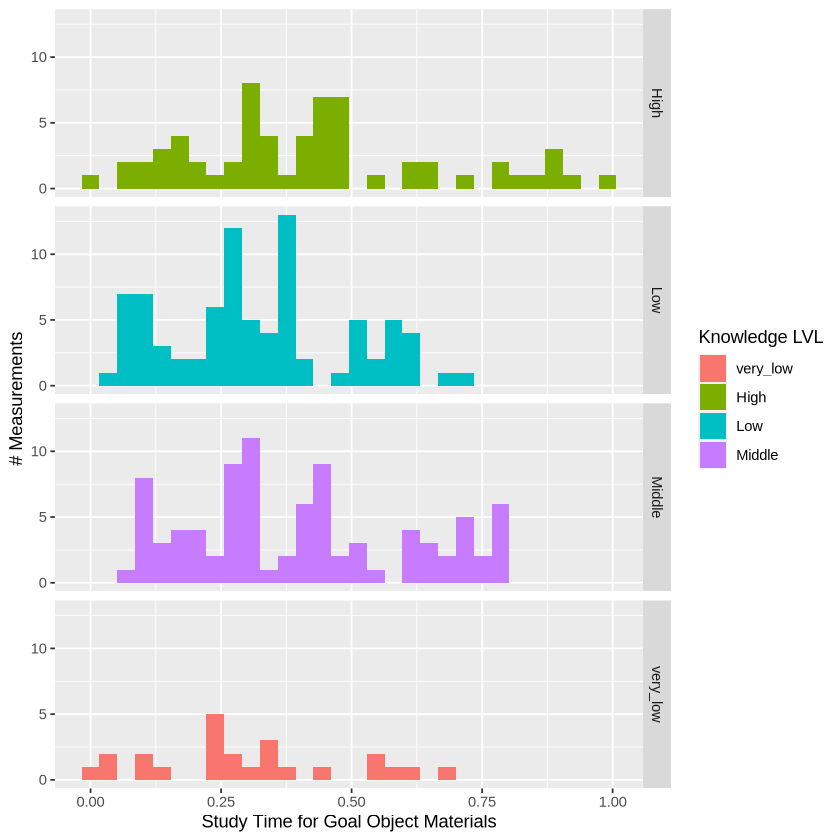

In [12]:
knowledge_STG_hist <- ggplot(knowledge, aes(x = STG, fill = as_factor(UNS))) +
  geom_histogram() +
  facet_grid(rows = vars(UNS)) +
  labs(x = "Study Time for Goal Object Materials", y = "# Measurements", fill = "Knowledge LVL")

knowledge_STG_hist